# Fifa world cup 2022 - Trying to predict match outcome (PCA & k-means analysis)

In this notebook I will try to predict the outcomes of the 2022 Fifa world cup matches, mixing supervised and unsupervised learning methods. In the first stage, I will perform PCA in order to reduce the dimensionality of the data. In the second stage I will perform k-means analysis in order to cluster the matches to 3 categories (corresponding to 3 possible outcomes of a football match).

### Initializing
#### Starting with loading the libraries:

In [1]:
library(tidyverse) # Useful data cleaning and analysis
library(psych) # For PCA
library(ggplot2) # Plotting
library(ggfortify) # ...
library(ggrepel) # ...
library(stringr) # Text and string manipulations

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.3.6      ✔ purrr   0.3.5 
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.2.1      ✔ stringr 1.4.1 
✔ readr   2.1.3      ✔ forcats 0.5.2 
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘psych’


The following objects are masked from ‘package:ggplot2’:

    %+%, alpha




#### Defining some helpful functions:

In [2]:
percent_to_prob <- function(percent) { # Transforming percentage data in the form of a string '56%' to numeric data between 0 and 1 (0.56)
  output <-  rep(NA, length(percent))
  for (i in 1:length(percent)) {
    output[i] <- as.numeric(gsub("%", "", percent[i]))/100 # Removing from every cell in the string vector the % sign, transforming to numeric and dividing by 100
  }
  return(output)
}


remove_vars_containing <- function(vars, forbidden) { # This function indetify and clean a vector of strings from items contatning spcified expressions
  for (word in forbidden) {                           # Looping for every forbidden expression
    vars <- vars[!str_detect(vars, regex(word, ignore_case = T))] # Keeping only the expressions that don't (the sign ! in the beginning) contain the forbidden word
  }
  return(vars)
}

### Loading the data and some pre-processing
After we load the data, we will define a new variable 'winner' that codes the winner of the match. We also transform some variables from string class to numeric class:

In [3]:
data <- read.csv("../input/fifa-world-cup-2022-complete-dataset/Fifa_world_cup_matches.csv") %>%
  mutate(winner = ifelse(number.of.goals.team1 > number.of.goals.team2, "team1",
                        ifelse(number.of.goals.team2 > number.of.goals.team1, "team2", "draw"))) %>% # Adding a 'Winner' variable.
  mutate(possession.team1 = percent_to_prob(possession.team1),
         possession.team2 = percent_to_prob(possession.team2),
         possession.in.contest = percent_to_prob(possession.in.contest)) # Transforming possesion percentage to numeric.

glimpse(data)

Rows: 64
Columns: 89
$ team1                                                 <chr> "QATAR", "ENGLAN…
$ team2                                                 <chr> "ECUADOR", "IRAN…
$ possession.team1                                      <dbl> 0.42, 0.72, 0.44…
$ possession.team2                                      <dbl> 0.50, 0.19, 0.45…
$ possession.in.contest                                 <dbl> 0.08, 0.09, 0.11…
$ number.of.goals.team1                                 <int> 0, 6, 0, 1, 1, 0…
$ number.of.goals.team2                                 <int> 2, 2, 2, 1, 2, 0…
$ date                                                  <chr> "20 NOV 2022", "…
$ hour                                                  <chr> "17 : 00", "14 :…
$ category                                              <chr> "Group A", "Grou…
$ total.attempts.team1                                  <int> 5, 13, 14, 6, 14…
$ total.attempts.team2                                  <int> 6, 8, 9, 7, 3, 1…
$ conceded.team1   

Second thing we will want to do is to remove variables with very low variance. For example: the variable 'goal.outside.the.penalty.area.team1' codes the number of goals scored by the home team in the match from outside the box. It looks like this:

In [4]:
summary(data$goal.outside.the.penalty.area.team1)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.00000 0.00000 0.00000 0.09375 0.00000 1.00000 

Therefore, we will want to remove those non-informative variables. We will do that using our function that detects (un)desired expressions in strings and removes them:

In [5]:
vars_full <- names(data) # Full list of variable names
forbidden_exp <- c("goal", "goals", "assist", "assists", "penalty", "penalties", "card", "cards", "conceded")
vars_analytics <- remove_vars_containing(vars_full, forbidden_exp) # Removing vars containing info about goals, assists and cards because of low variance.

#### Final filtering and end of pre-processing
Selecting the desired variables:

In [6]:
data_for_pca <- data %>%
  select(all_of(vars_analytics)) %>% # Selecting relatively high variance vars.
  select(-team1, -team2, -date, -hour, -category, -winner) # Removing non numeric vars.

### PCA (Principal Components Analysis)
We are left with 59 variables which is quite a large number if we desire some explainability by the end of the process ;). Therefore we will perform some PCA in order to reduce those 59 variables to some smaller number of features.

If you are interested in learning more about PCA. check out this helpful video by StatQuest (Josh Starmer): https://www.youtube.com/watch?v=FgakZw6K1QQ

We will start with calculating 59 PC's:

In [7]:
pc_fit <- prcomp(~ ., data_for_pca, scale = T)
summary(pc_fit)

Importance of components:
                          PC1     PC2     PC3     PC4     PC5     PC6     PC7
Standard deviation     4.8252 2.29457 2.01125 1.82599 1.62346 1.45476 1.38953
Proportion of Variance 0.3946 0.08924 0.06856 0.05651 0.04467 0.03587 0.03273
Cumulative Proportion  0.3946 0.48386 0.55242 0.60893 0.65360 0.68947 0.72220
                           PC8     PC9    PC10    PC11    PC12   PC13    PC14
Standard deviation     1.29794 1.18285 1.06947 1.00395 0.99218 0.9563 0.92881
Proportion of Variance 0.02855 0.02371 0.01939 0.01708 0.01669 0.0155 0.01462
Cumulative Proportion  0.75075 0.77447 0.79385 0.81094 0.82762 0.8431 0.85774
                          PC15   PC16    PC17    PC18    PC19    PC20    PC21
Standard deviation     0.86947 0.8621 0.85836 0.80441 0.75369 0.72136 0.67813
Proportion of Variance 0.01281 0.0126 0.01249 0.01097 0.00963 0.00882 0.00779
Cumulative Proportion  0.87056 0.8831 0.89564 0.90661 0.91623 0.92505 0.93285
                          PC22    PC23

##### That's a scary output...
As expected, only the first two PC's are helpful in explaining the variance between data points. Therefore we can use them in analyses without losing much of the explainied variance.

Each PC is a linear combination of the original 59 variables, we can see the coefficients of the first two PC's (also called the eigenvector's components or loadings):

In [8]:
metrics <- principal(data_for_pca, nfactors = 2, rotate = "none")
metrics$loadings

Warning message in cor.smooth(r):
“Matrix was not positive definite, smoothing was done”
Warning message in principal(data_for_pca, nfactors = 2, rotate = "none"):
“The matrix is not positive semi-definite, scores found from Structure loadings”



Loadings:
                                                      PC1    PC2   
possession.team1                                      -0.958       
possession.team2                                       0.948       
possession.in.contest                                              
total.attempts.team1                                  -0.533  0.347
total.attempts.team2                                   0.679  0.331
on.target.attempts.team1                              -0.362  0.331
on.target.attempts.team2                               0.504  0.302
off.target.attempts.team1                             -0.441  0.279
off.target.attempts.team2                              0.537  0.251
left.channel.team1                                    -0.709  0.138
left.channel.team2                                     0.776  0.290
left.inside.channel.team1                             -0.415       
left.inside.channel.team2                              0.601  0.391
central.channel.team1                

We can also see the values of each data point on the two PC's. Those are the 'scores' variable in the 'metrics' object:

In [9]:
metrics$scores

PC1,PC2
3.8290127,-7.4299046
-46.9345186,-1.9290034
2.5253652,1.1351010
-12.0792919,-1.2713940
-35.0252017,4.3518621
-17.2310447,0.9885101
-21.9414947,0.4299926
-28.6874057,3.2600220
16.9713053,-7.8763388
-41.2481328,8.7804669


## Plotting!
Let's plot the data on the 2-dimensions of PC1 and PC2. we will also color the points with the actual outcome of the match (i.e. the actual labels):

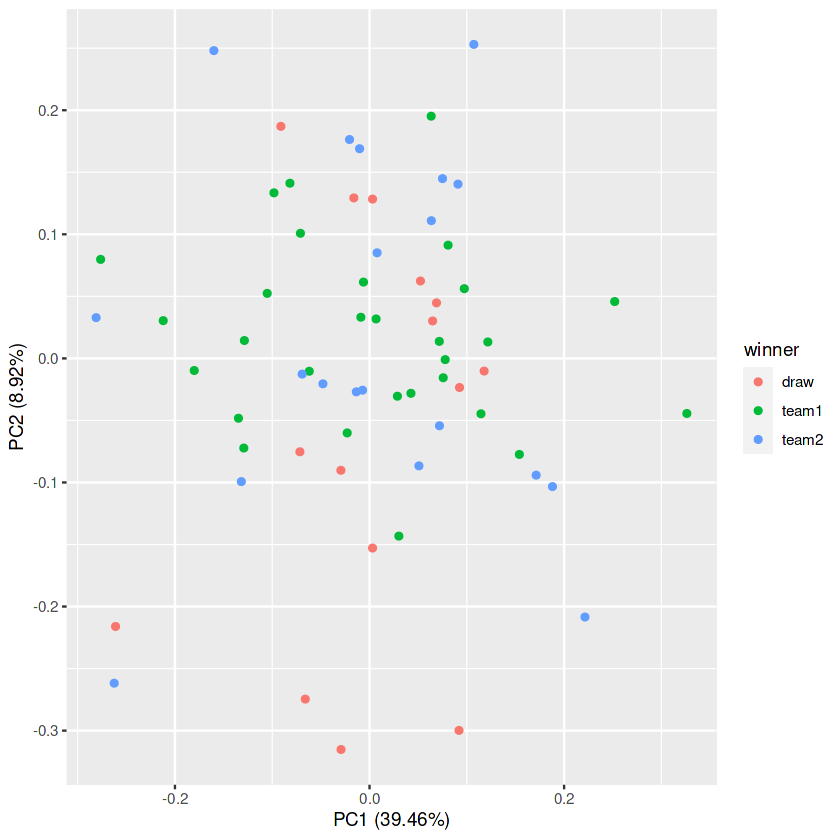

In [10]:
autoplot(pc_fit, data = data, colour = "winner")


On this 2-dimension space we can also try and cluster the points without supervision, using the k-means method.
First some cleaning:

In [11]:
data_for_kmeans <- data.frame(cbind(metrics$scores, data$winner)) %>% # Combining PC1 and PC2 with the actual labels in order to plot later.
  mutate(PC1 = as.numeric(PC1), PC2 = as.numeric(PC2)) %>%
  select(PC1, PC2, winner = V3)

Performing the k-means analysis:

In [12]:
kmeans <- kmeans(data_for_kmeans[,1:2], centers = 3, nstart = 10) # Performing the analysis on the first two variables (PC1 & PC2), trying to find 3 clusters.

Addind the cluster variable to the data frame:

In [13]:
data_for_kmeans$cluster <- factor(kmeans$cluster)

### Finally...
Plotting the data points on the 2-dimension space of PC1 and PC2 (our most significant components), colored by their cluster found in the k-means analysis and headed by their actual label:

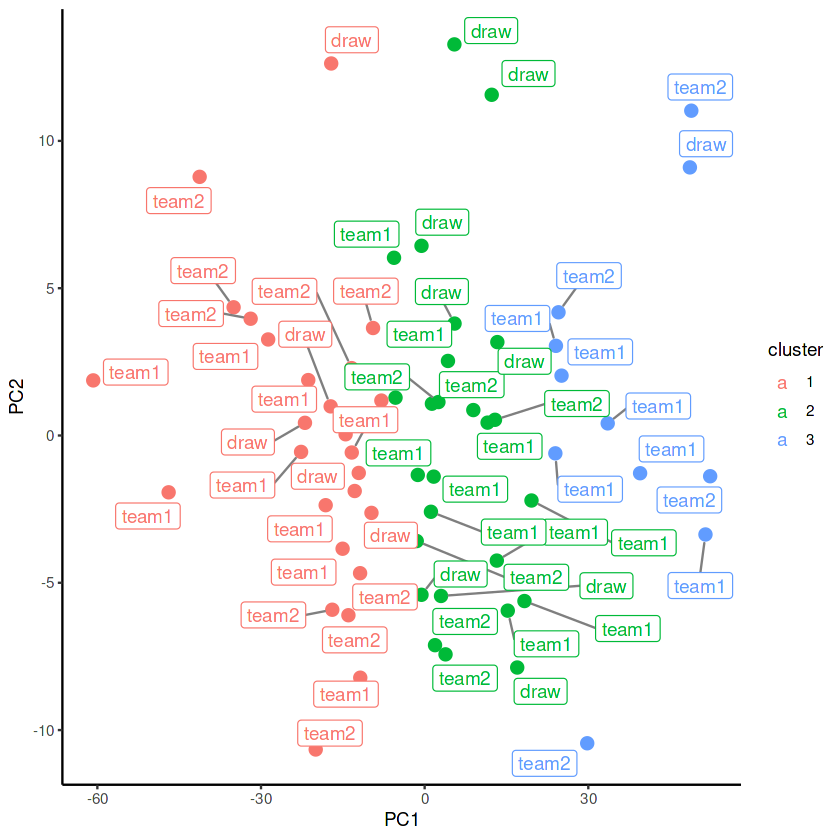

In [14]:
plot <- ggplot(data_for_kmeans, aes(x = PC1, y = PC2, color = cluster)) + 
  geom_point(size = 3) + 
  geom_label_repel(aes(label = winner),
                   box.padding   = 0.35, 
                   point.padding = 0.5,
                   segment.color = 'grey50') +
  theme_classic()

plot

### Nice!
unfortunately, the clusters and labels seem to be independent of eachother, meaning that we couldn't predict the outcome of the matches successfully :\
This can be indicated by this frequancy table:

In [15]:
freq_table <- table(data_for_kmeans$winner, data_for_kmeans$cluster)
freq_table

       
         1  2  3
  draw   6  8  1
  team1 12 11  6
  team2  9  7  4

And this insignificant chi-square test of independence:

In [16]:
chisq.test(freq_table)

Warning message in chisq.test(freq_table):
“Chi-squared approximation may be incorrect”



	Pearson's Chi-squared test

data:  freq_table
X-squared = 2.1279, df = 4, p-value = 0.7123
